In [350]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions

In [466]:
batch_size = 32  # number of inputs in each batch
epochs = 10  # times to run the model on complete data
lr = 1e-3  # learning rate
train_loss = []
image_size = 32  # dimension of the image
hidden_size = 1024  # hidden dimension
latent_size = 32  # latent vector dimension
train_data = datasets.SVHN(
    ".",
    split="train",
    download=True,
    transform=transforms.Compose([transforms.Resize(64), transforms.ToTensor()]),
)
test_data = datasets.SVHN(
    ".",
    split="test",
    download=True,
    transform=transforms.Compose([transforms.Resize(64), transforms.ToTensor()]),
)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [467]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)


class ConvVAE(nn.Module):
    def __init__(
        self,
        image_channels=3,
        image_dim=32,
        hidden_size=hidden_size,
        latent_size=latent_size,
    ):
        super(ConvVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(64, 128, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(128, 256, 4, 2),
            nn.ReLU(0.2),
            Flatten(),
        )
        self.encoder_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_logvar = nn.Linear(hidden_size, latent_size)
        self.fc = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(hidden_size, 128, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 6, 2),
            nn.Sigmoid(),
        )
        self.z = None

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = self.encoder(x)
        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)
        z = self.sample(log_var, mean)
        x = self.fc(z)
        self.z = z
        x = self.decoder(x)
        return x, mean, log_var

In [455]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [456]:
@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None):
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        reconstructed_image, mean, log_var = model(images)
                 
        CE = F.binary_cross_entropy(reconstructed_image, images, reduction="sum")
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss = CE + KLD
        loss_list.append(loss.item())
        recons_loss.append(CE.item())
        kld_loss.append(KLD.item())
        
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss

In [457]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, mu, log_var = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list

In [458]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

In [468]:
vae = ConvVAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)



In [469]:
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=testloader, num_epochs=15
    )

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e1e2d700>
Traceback (most recent call last):
  File "/home/user/bhuttam0/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/user/bhuttam0/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/user/bhuttam0/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f87e1e2d700>
Traceback (most recent call last):
  File "/home/user/bhuttam0/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at

    Train loss: 0.03871
    Valid loss: 273060.23075
       Valid loss recons: 273059.969
       Valid loss KL-D:   0.26433



Epoch 6 Iter 2290: loss 0.04168. : 100%|██████████| 2290/2290 [00:18<00:00, 125.88it/s]

    Train loss: 0.03863
    Valid loss: 271105.5673
       Valid loss recons: 271105.53607
       Valid loss KL-D:   0.02725



Epoch 8 Iter 2290: loss 0.04624. : 100%|██████████| 2290/2290 [00:18<00:00, 123.68it/s]

Epoch 00008: reducing learning rate of group 0 to 3.0000e-04.



Epoch 11 Iter 2290: loss 0.02630. : 100%|██████████| 2290/2290 [00:17<00:00, 127.86it/s]

    Train loss: 0.03861
    Valid loss: 271080.88314
       Valid loss recons: 271080.88314
       Valid loss KL-D:   0.00875



Epoch 14 Iter 2290: loss 0.05425. : 100%|██████████| 2290/2290 [00:18<00:00, 122.01it/s]

Epoch 00014: reducing learning rate of group 0 to 3.0000e-05.



Epoch 15 Iter 2290: loss 0.04945. : 100%|██████████| 2290/2290 [00:18<00:00, 125.57it/s]

    Train loss: 0.03862
    Valid loss: 271093.47364
       Valid loss recons: 271093.47364
       Valid loss KL-D:   0.00995
Training completed


In [393]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


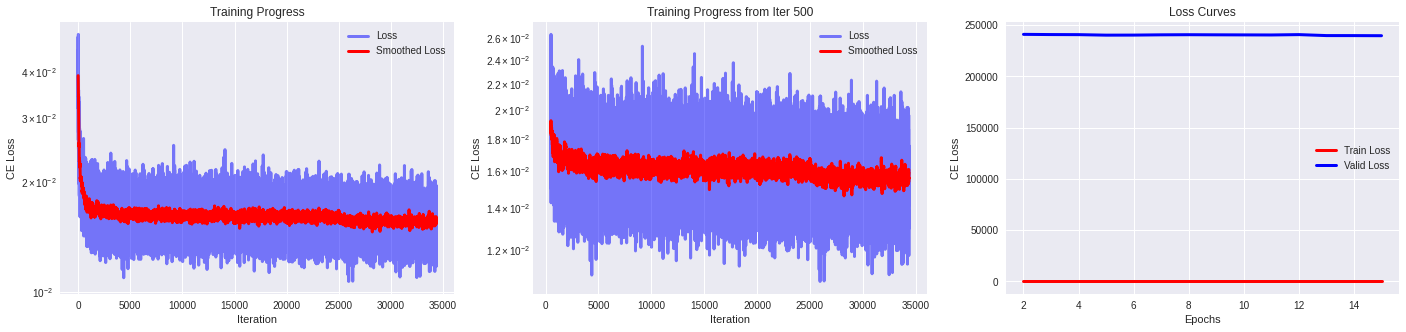

In [395]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

This training graph clearly shows that the model is learning on training data. The last graph is a bit vague due the to fact that the validation loss is fluctuating, a bit (like +-200), but we cannot see to see the behavior. But, still this is not just to deduce anything about the quality of model, it is most likely overfitting heavily.

In [438]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [439]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in testloader:
        imgs = imgs.to(device)
        img,mu,var = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(vae.z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [440]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [441]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

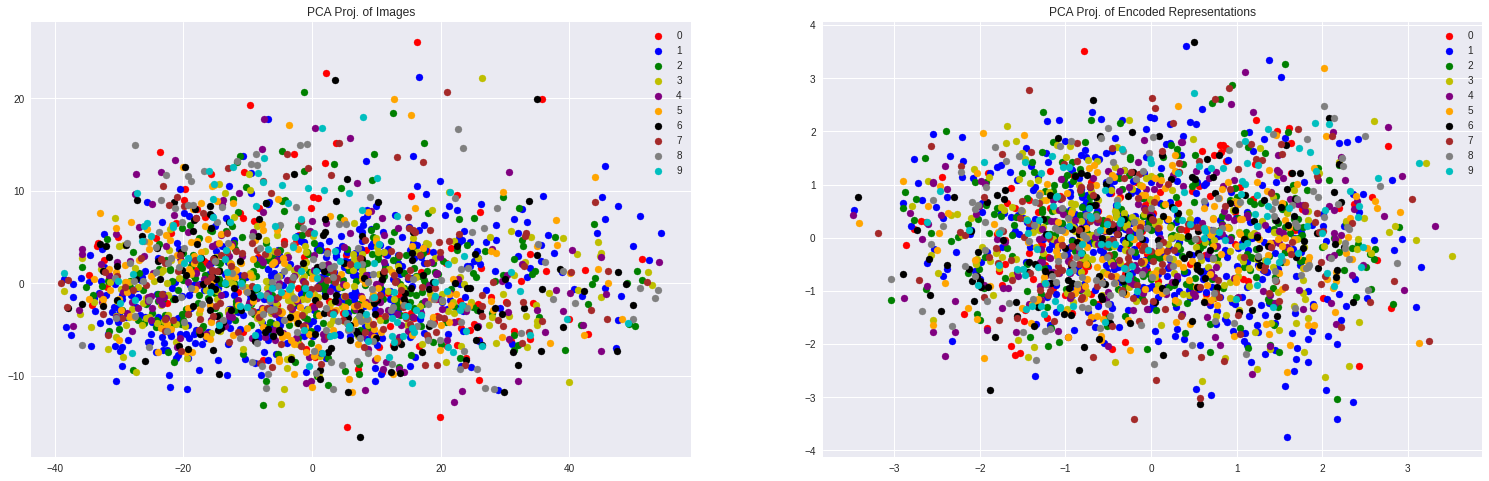

In [411]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=[str(i) for i in range(0,10)])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=[str(i) for i in range(0,10)])
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

There is not much of information here in these graphs. The model is too shallow in my opinion and see to make bad latent representations which are not distinguishable. 
One reason could be the fact that in some of the image, there are mutiple digits (see below image for reference). So, trying to divide these latent encodings into 10 classes is a bit too much to our model as of now. 

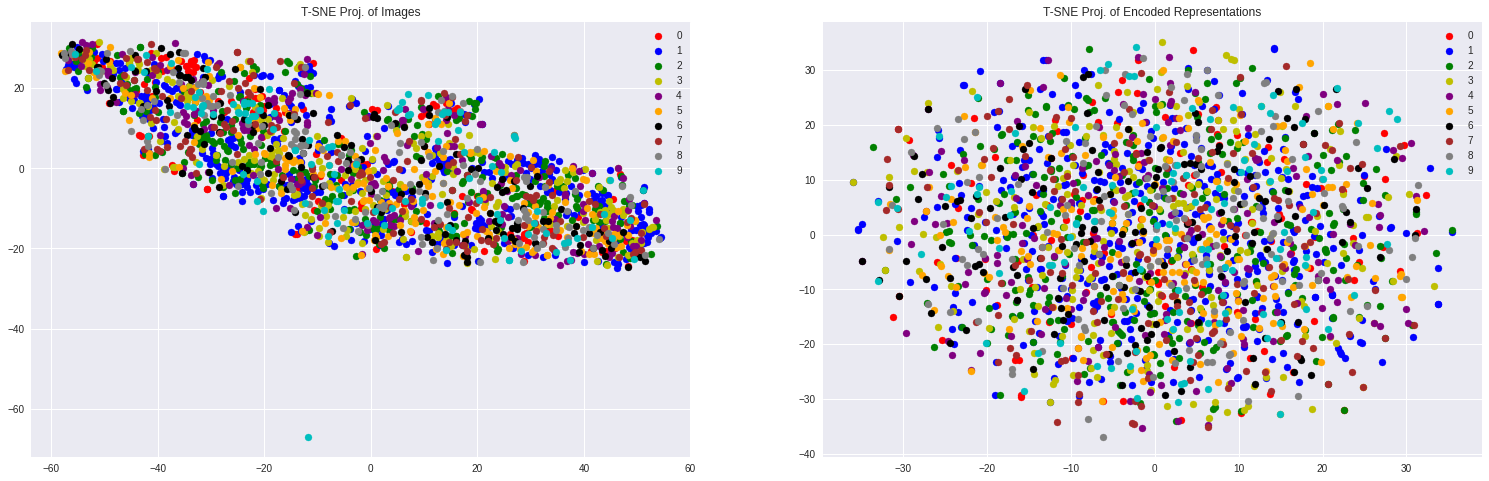

In [412]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=[str(i) for i in range(0,10)])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1], legend=[str(i) for i in range(0,10)])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

In [415]:
@torch.no_grad()
def img_regeneration(model):
    test_z = torch.randn(32, 1024).to(device)
    out = model.decoder(test_z)
    return out

In [416]:
X,_ = None,None
for i in testloader:
    X,_ = i
    break

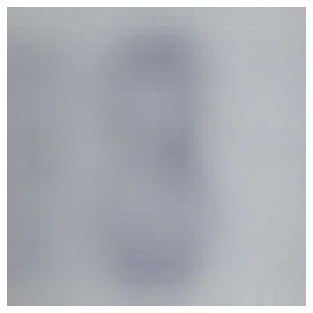

In [444]:
vae = vae.cuda()
out,_,_ = vae(X.to(device))
out = out.detach().cpu()
p = out[10].permute(1,2,0)
plt.imshow(p.to("cpu"));
plt.axis("off");

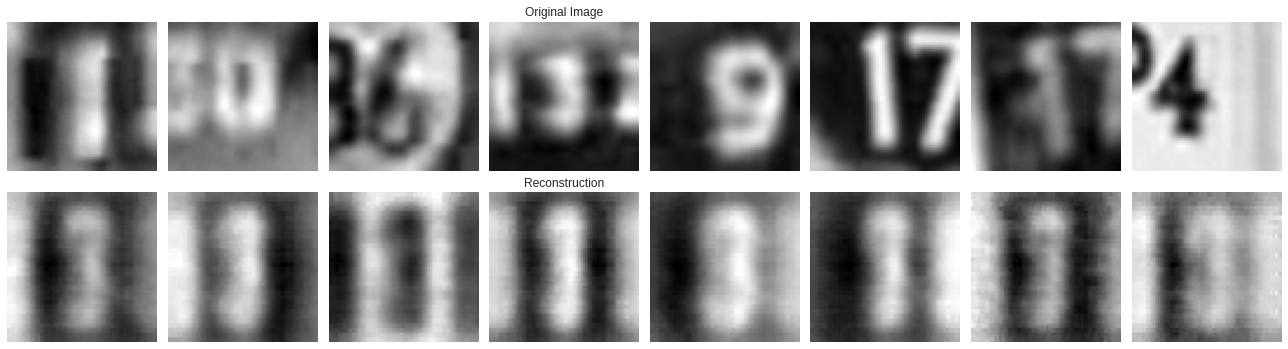

In [418]:
imgs, _ = next(iter(testloader)) 

vae.eval()
with torch.no_grad():
    recons, _,__ = vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [470]:
#From this above recontruction, we can see that the model is trying to learn the reconstructed_images and it is heading in a positive direction as we can make sense of some of
#the images

In [419]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in testloader:
        imgs = imgs.to(device)
        _,_,z = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [471]:
@torch.no_grad()
def plot_interpolations(model, xrange=(-1, 1), N=10):
    all_img = []
    for x in torch.linspace(*xrange, N):
        z = vae_.fc(torch.full((256,32), x))
        x_hat = model.decoder(z)
        all_img.append(x_hat[0:10])

    all_img = torch.cat(all_img)
    grid_imgs = torchvision.utils.make_grid(all_img, nrows=4)
    plt.figure(figsize=(12,20))
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.axis("off")

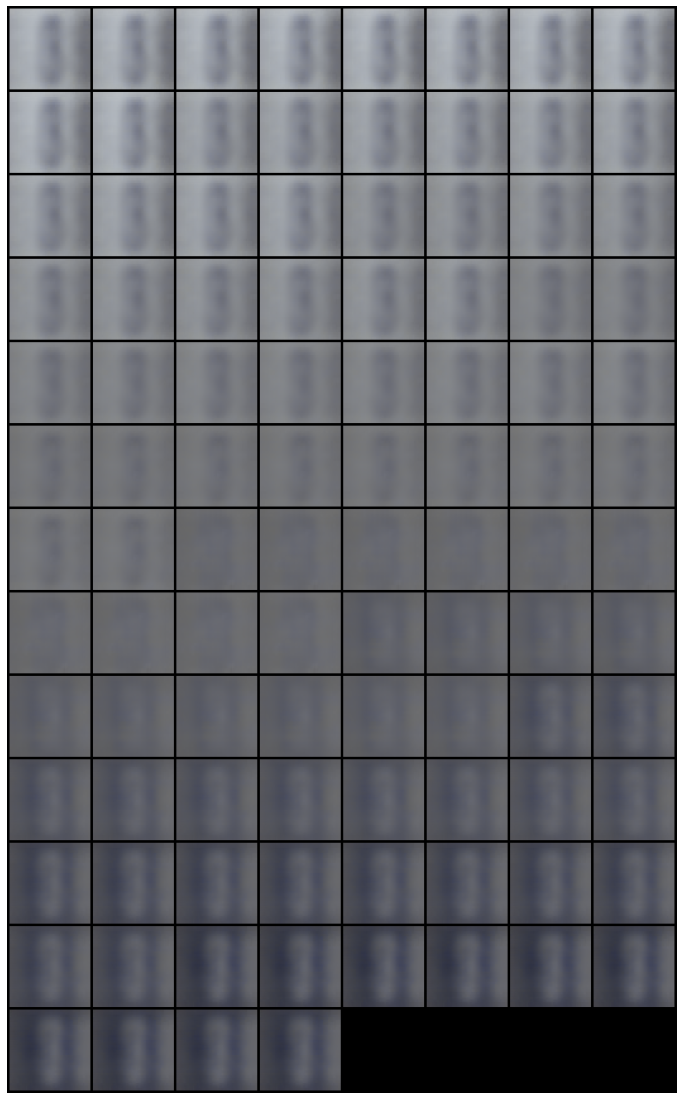

In [472]:
imgs = plot_interpolations(vae_.to("cpu"))


In the above cell's out we see how the regenerations look when we change the hidden vector. There are 32 dims of the hidden space and changing each of the dimension would result in different images. So we chose the hidden vector such that all the values of z are same when regenerating one image and the value of z range from [-1, 1] for all the 64 images regenerated. It looks like the model is trying to learn the digit with different brightness and different edges, but it is still blurry and it has a long way to learn better latent encodings

**FID**

As we could not do the second question of this assignment, it is not possible to do the FID part. I have written an algorithm that outlines how this works, but it is without any results.

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import adaptive_avg_pool2d
import numpy as np

# Load the pre-trained Inception v3 model
inception_model = torch.hub.load('pytorch/vision', 'inception_v3', pretrained=True)
# Set the model to evaluation mode
inception_model.eval()

# Calculate the activations of the Inception v3 model for a set of generated and real images
def get_activations(images, model):
    # Set the model to evaluation mode
    model.eval()
    # Forward pass the images through the model
    outputs = model(images)
    # Outputs are (N,C,H,W), Adaptive avg pooling to (1,C,1,1)
    features = adaptive_avg_pool2d(outputs, (1,1)).view(outputs.size(0), -1)
    # Return the features
    return features

# Generate a set of fake images using model_a
fake_images_a = model_a.generate(num_images)
# Generate a set of fake images using model_b
fake_images_b = model_b.generate(num_images)
# Get the activations of the Inception v3 model for the generated images
fake_act_a = get_activations(fake_images_a, inception_model)
fake_act_b = get_activations(fake_images_b, inception_model)

# Get the activations of the Inception v3 model for a set of real images
real_act = get_activations(real_images, inception_model)

# Calculate the mean and covariance of the generated images
mu_a = fake_act_a.mean(dim=0)
sigma_a = fake_act_a.cov(rowvar=False)

mu_b = fake_act_b.mean(dim=0)
sigma_b = fake_act_b.cov(rowvar=False)

# Calculate the mean and covariance of the real images
real_mu = real_act.mean(dim=0)
real_sigma = real_act.cov(rowvar=False)

# Calculate the Fréchet Distance between the generated images and the real images
fid_a = ((mu_a - real_mu) ** 2).sum() + np.trace(sigma_a + real_sigma - 2 * np.sqrt(np.matmul(sigma_a, real_sigma)))
fid_b = ((mu_b - real_mu) ** 2).sum() + np.trace(sigma_b + real_sigma - 2 * np.sqrt(np.matmul(sigma_b, real_sigma)))

print("FID for model_a: ",fid_a)
print("FID for model_b: ",fid_b)


**Extra Parts**

In [ ]:

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import lpips
import optuna
import optuna.visualization.matplotlib as oplt
from tqdm import tqdm
from torch import Tensor
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchsummary import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('seaborn')


train_dataset = datasets.SVHN(
    root='./data/', split='train', transform=T.ToTensor(), download=True)
validation_dataset = datasets.SVHN(
    root='./data/', split='extra', transform=T.ToTensor(), download=True)
test_dataset = datasets.SVHN(
    root='./data/', split='test', transform=T.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, drop_last=False)
validation_loader = DataLoader(
    validation_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=16,
                         shuffle=True, drop_last=False)


# using model resnet18 having 18 layers
# downloading pretrained model
resnet = models.resnet18(pretrained=True)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class Resnet18Decoder(nn.Module):
    def __init__(self, z_dim: int):
        super().__init__()
        # layers are in reverse order in order to mirror the encoder
        self.fc = nn.Linear(z_dim, 512)
        self.unflatten = nn.Unflatten(1, (512, 1, 1))

        # undo avaerage pool
        self.upSample6 = nn.Upsample(size=(7, 6))
        self.layer4 = self._make_layer(c_in=512, c_out=256)

        # undo stride in layer4
        self.upSample5 = nn.Upsample(size=(14, 12))
        self.layer3 = self._make_layer(c_in=256, c_out=128)

        # undo stride in layer3
        self.upSample4 = nn.Upsample(size=(28, 23))
        self.layer2 = self._make_layer(c_in=128, c_out=64)

        # undo stride in layer2
        self.upSample3 = nn.Upsample(size=(55, 45))
        self.layer1 = self._make_layer(c_in=64)

        # undo max pool
        self.upSample2 = nn.Upsample(size=(109, 89))
        self.conv1 = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(
            3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # undo stride in conv1
        self.upSample1 = nn.Upsample(size=(32, 32))

    def _make_layer(self, c_in: int, c_out: int = None):
        layers = []
        # both blocks are same due to no downsampling applied
        layers.append(BasicBlock(c_in))
        layers.append(BasicBlock(c_in))
        # changing the number of channels in different layers
        if c_out is not None:
            layers.append(nn.Conv2d(c_in, c_out, 1))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.upSample6(x)
        x = self.layer4(x)
        x = self.upSample5(x)
        x = self.layer3(x)
        x = self.upSample4(x)
        x = self.layer2(x)
        x = self.upSample3(x)
        x = self.layer1(x)
        x = self.upSample2(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.upSample1(x)
        x = torch.sigmoid(x)
        return x


class ResNet18VAE(nn.Module):
    def __init__(self, z_dim: int):
        super().__init__()
        self.encoder = resnet
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, z_dim * 2)
        self.decoder = Resnet18Decoder(z_dim=z_dim)

    def forward(self, x: Tensor):
        # reparameterization
        mean, logvar = torch.chunk(self.encoder(x), chunks=2, dim=-1)
        std = torch.exp(logvar/2)
        # sampling
        epsilon = torch.randn_like(std)
        # latent vector
        z = epsilon * std + mean  
        # reconstruction
        x = self.decoder(z)
        # return x, z
        return x, z, logvar, mean



# Function TRAIN_EPOCH
# Model dataset training and validation functions
# Parameters
# Model Selection: ResNet18
# Train Loader
# Optimizer: Adam
# KL Divergence Loss
# Epoch: 15
# Device: Cuda

def train_epoch(model, train_loader, epoch, device,optimizer):
    """ Training a model for one epoch """
    
    loss_list = []
    train_loss = []
    validation_loss = []
    pbar_train = tqdm(train_loader, total=len(train_loader))
    for images, _ in pbar_train:
        # using images and labels on GPU
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/log odss function
        outputs = model(images)
         
        # Calculate Loss: KL divergence loss
        reconstructions, z, log_var, mean = model(images)
        # KL Divergence loss
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var -
                                  mean ** 2 - log_var.exp(), dim=1), dim=0)
        loss = F.mse_loss(images, reconstructions) + kld_loss
        loss_list.append(loss.item())
        mean_loss = np.mean(loss_list)   
        # Getting gradients w.r.t. parameters
        loss.backward()
        pbar_train.set_description(
                f'Epoch {1}: training loss = {mean_loss:.8f}.')
        # Updating parameters
        optimizer.step()
        
    train_loss.append(mean_loss)
    return train_loss

# Function EVAL_MODEL
# Parameters
# Model Selection: ResNet18
# Evaluation Loader
# KL Divergence Loss
# Device: Cuda

@torch.no_grad()
def eval_model(model, eval_loader, device, epoch):
    """ Evaluating the model for either validation or test """
    # saving individual loss at each epoch
    loss_list = []
    pbar_val = tqdm(validation_loader, total=len(validation_loader))
    for images, _ in pbar_val:
        images = images.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        # Calculate Loss: KL divergence loss
        reconstructions, z, log_var, mean = model(images)
        # KL Divergence loss
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var -
                                  mean ** 2 - log_var.exp(), dim=1), dim=0)
        loss = F.mse_loss(images, reconstructions) + kld_loss
        loss_list.append(loss.item())
        mean_loss = np.mean(loss_list)
        pbar_val.set_description(
                f'Epoch {1}: validation loss = {mean_loss:.8f}.')

            
    validation_loss.append(mean_loss)
    return validation_loss

# Function TRAIN_MODEL
# Parameters
# Model Selection: ResNet18
# Optimzer: Adam
# LR Scheduler: STEPLR
# KL Divergence Loss
# Train Loader
# Evaluation Loader
# Number of Epochs: 15

def train_model(model,optimizer, train_loader, valid_loader, num_epochs, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    # loss (train and validation) and validation accuracy lists saving repective accuracies and losses for each epoch
    train_loss = []
    val_loss =  []
    for epoch in range(num_epochs):
        # validation epoch
        # important for dropout and batch norms
        # training epoch
        model.train()  # important for dropout and batch norms
   
        mean_loss_train = train_epoch(
                model=model, train_loader=train_loader,
                epoch=epoch, device=device,optimizer=optimizer
            )

        model.eval()        
        mean_loss_validation = eval_model(
                    model=model, eval_loader=valid_loader,
                    device=device, epoch = epoch
            )
        
        val_loss.append(mean_loss_validation)
        train_loss.append(mean_loss_train)
    
    print(f"Training completed")
    return train_loss, val_loss

resnet_vae = ResNet18VAE(z_dim=100).to(device)

optimizer = torch.optim.Adam(resnet_vae.parameters(), lr=3e-4)
train_loss, validation_loss = train_model(
        model=resnet_vae, optimizer=optimizer,
        train_loader=train_loader, valid_loader=validation_loader, num_epochs=10
    )


# plots and visualization curves for training, loss curves and validation accuracy
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, validation_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

plt.show()


def betaVAE(trial: optuna.Trial):
    model = ResNet18VAE(100).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    beta = trial.suggest_int('beta', 2, 250)
    progress_bar = tqdm(range(10), total=10)
    for epoch in progress_bar:
        model.train()
        for images, _ in train_loader:
            # using images on GPU
            images = images.to(device)            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()            
            # Forward pass to get output/log odss function
            outputs = model(images)
            
            # Calculate Loss: KL divergence loss
            reconstructions, z, log_var, mean = model(images)
            # KL Divergence loss
            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var -
                                      mean ** 2 - log_var.exp(), dim=1), dim=0)
            loss = F.mse_loss(images, reconstructions) + kld_loss
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            loss_list = []
            for images, _ in validation_loader:
                images = images.to(device)
                # Forward pass only to get logits/output
                outputs = model(images)                        
                # Calculate Loss: KL divergence loss
                reconstructions, z, log_var, mean = model(images)
                # KL Divergence loss
                kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var -
                                          mean ** 2 - log_var.exp(), dim=1), dim=0)
                loss = F.mse_loss(images, reconstructions) + kld_loss
                loss_list.append(loss.item())
        validation_loss = np.mean(loss_list)
        trial.report(validation_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return validation_loss


study = optuna.create_study(study_name='betaVae', direction='minimize')
study.optimize(betaVAE, n_trials=20)